Fraction Unbound (Human)
Description: Fraction unbound (FU) refers to the proportion of a small molecule drug that is not bound to proteins in the bloodstream of humans. FU is an important pharmacokinetic property because only the unbound fraction of a drug is typically available to exert pharmacological effects or be metabolized and eliminated from the body. Therefore, it directly influences the drug's potency, efficacy, and potential for adverse effects.



In pharmacokinetics and pharmacology, Fraction Unbound (Human), also known as fu (human), refers to the fraction of a drug that is unbound or free in the plasma. It represents the proportion of the drug that is not bound to plasma proteins and is available for distribution and pharmacological action.

High Fraction Unbound (fu): A high fraction unbound indicates that a larger portion of the drug is in its free form and available for distribution to tissues and interaction with its target receptors or enzymes. This can lead to increased pharmacological activity and efficacy, as a higher concentration of the drug is present in the bloodstream and able to exert its effects.

Low Fraction Unbound (fu): Conversely, a low fraction unbound suggests that a significant portion of the drug is bound to plasma proteins, reducing its availability for distribution and pharmacological action. While a low fu may increase the drug's plasma half-life and stability, it can also decrease its pharmacological activity and efficacy as less free drug is available to interact with target sites.

The optimal fraction unbound for a given drug depends on various factors, including its pharmacokinetic and pharmacodynamic properties, therapeutic index, and desired clinical outcomes. Therefore, the significance of the fraction unbound in drug therapy depends on the specific context and the therapeutic goals of the treatment.

With the information provided, here are some strategies to potentially improve your model:

### 1. Feature Engineering:
- **Feature Selection**: Analyze the importance of each feature and consider removing irrelevant or redundant ones. You have a large number of features, so feature selection techniques like Recursive Feature Elimination (RFE) or feature importance from a tree-based model could be beneficial.
- **Feature Scaling**: Ensure all features are scaled appropriately, especially if they have different scales.

### 2. Model Architecture:
- **Simplification**: The current model architecture is quite complex, which may lead to overfitting, especially given the large number of features. Consider reducing the number of layers or neurons to simplify the model.
- **Regularization**: Regularization techniques like dropout and L2 regularization can help prevent overfitting. However, you should carefully tune the dropout rate and regularization strength to find the optimal balance.

### 3. Hyperparameter Tuning:
- **Learning Rate**: Experiment with different learning rates to find the one that results in faster convergence without oscillating or diverging.
- **Batch Size**: Adjust the batch size and monitor the training dynamics. Smaller batch sizes often generalize better but may result in slower convergence.
- **Optimizer**: Besides Adam, try other optimizers such as RMSprop or SGD with momentum, and tune their parameters accordingly.

### 4. Training Strategy:
- **Early Stopping**: The `EarlyStopping` callback is already included, but you can further tune its parameters like the `patience` to stop training at the right moment.
- **Learning Rate Scheduler**: Instead of a fixed learning rate, consider using a learning rate scheduler to dynamically adjust the learning rate during training.

### 5. Cross-Validation:
- Perform k-fold cross-validation to assess the model's stability and generalization performance across different subsets of the data.

### 6. Data Augmentation:
- If you have limited data, consider applying data augmentation techniques to artificially increase the size of your training set.

### 7. Model Evaluation:
- Besides the test loss, evaluate the model on other metrics relevant to your problem, such as accuracy, precision, recall, or F1 score, especially if your problem is a classification task.

### Example Workflow:
1. **Feature Selection**: Identify the most important features using feature importance techniques.
2. **Model Simplification**: Reduce the complexity of the model architecture.
3. **Hyperparameter Tuning**: Tune hyperparameters using techniques like grid search or random search.
4. **Cross-Validation**: Assess model performance using k-fold cross-validation.
5. **Evaluation**: Evaluate the model on multiple metrics and compare with baseline models or other algorithms.

By systematically going through these steps and experimenting with different configurations, you should be able to iteratively improve your model's performance. Remember to keep track of your experiments and document your findings to make informed decisions.

In [1]:
import pandas as pd

In [2]:
!pip install rdkit
!pip install Sklearn
!pip install tensorflow
import numpy as np
from rdkit import Chem
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.models import save_model
from keras import optimizers

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
    

2024-05-16 20:57:39.424773: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-16 20:57:40.506447: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-16 20:57:42.854769: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-16 20:57:46.330022: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [42]:
data_fu = pd.read_csv("data/fu_train.csv", header=0)
test = pd.read_csv("data/fu_test.csv", header=0)
data_fu= pd.concat([data_fu, test])

data_fu.columns = ['smiles', 'label', 'group']

In [43]:
data_fu['Molecule'] = data_fu['smiles'].apply(Chem.MolFromSmiles)

In [44]:
data_fu.shape

(2139, 4)

In [45]:
from rdkit.Chem import Descriptors, AllChem
# Function to calculate all molecular descriptors for a molecule
def calculate_all_descriptors(molecule):
    descriptors = {}
    for descriptor, descriptor_fn in Descriptors.descList:
        descriptors[descriptor] = descriptor_fn(molecule)
    return descriptors

# Calculate all molecular descriptors for each molecule
all_descriptors = data_fu['Molecule'].apply(calculate_all_descriptors)

# Convert dictionary of descriptors into dataframe
descriptor_df = pd.DataFrame(all_descriptors.tolist())

# Concatenate the original dataframe with the descriptor dataframe
data_fu_descriptor = pd.concat([data_fu, descriptor_df], axis=1)

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [ ]:
data_fu_descriptor.columns[data_fu_descriptor.isna().any()].tolist()

[]

In [ ]:
list_desc =  [descr[0] for descr in Descriptors.descList]

In [ ]:
X = data_fu_descriptor[list_desc].values
y = data_fu_descriptor['label'].values

In [11]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Trying without scaler to capture variability 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [12]:
X_train_scaled.shape

(1520, 210)

Epoch 1/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3.0971 - val_loss: 2.7622 - learning_rate: 0.0010
Epoch 2/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3210 - val_loss: 2.5117 - learning_rate: 0.0010
Epoch 3/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2042 - val_loss: 2.1847 - learning_rate: 0.0010
Epoch 4/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.0646 - val_loss: 2.1021 - learning_rate: 0.0010
Epoch 5/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9523 - val_loss: 2.0102 - learning_rate: 0.0010
Epoch 6/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8951 - val_loss: 1.9952 - learning_rate: 0.0010
Epoch 7/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8514 - val_loss: 1.9454 - learning_rate: 0.0010
Epoch 8/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8052 - val_loss: 1.9184 - learning_rate: 0.0010
Epoch 9/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7435 - val_loss: 1.8879 - learning_rate: 0.0010
Epoch 10/500
71/71 

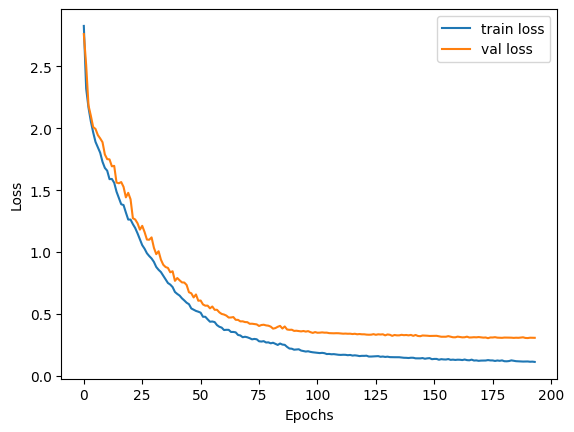

In [66]:
from keras import optimizers, callbacks

model = models.Sequential([
    layers.Dense(200, activation='relu', input_shape=(X_train_scaled.shape[1],), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dropout(0.5),  # Regularization
    layers.Dense(400, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),  # Increased complexity
    layers.Dropout(0.5),
    layers.Dense(400, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),  # Increased complexity
    layers.Dropout(0.5),
    layers.Dense(200, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),  # Increased complexity
    layers.Dropout(0.5),
    layers.Dense(200, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(100, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dense(1)  # Output layer
])

# Compile the model with a lower learning rate
learning_rate = 0.001
optimizer = optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='mean_squared_error')

# Define callbacks for early stopping and learning rate reduction
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model with more epochs and callbacks
history = model.fit(X_train_scaled, y_train, 
                    epochs=500, 
                    validation_split=0.3, 
                    batch_size=15, 
                    verbose=1, 
                    callbacks=[early_stopping, reduce_lr])

# Plotting training and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [55]:
# learning_rate = 0.001
# from keras import optimizers, callbacks

# model = models.Sequential([
#     layers.Dropout(0.5),  # Regularization
#     layers.Dense(200, activation='relu', input_shape=(X_train_scaled.shape[1],)),
#     layers.Dropout(0.5),
#     layers.Dense(400, activation='relu'),  # Increased complexity
#     layers.Dropout(0.5),
#     layers.Dense(400, activation='relu'),  # Increased complexity
#     layers.Dense(200, activation='relu'),  # Increased complexity
#     layers.Dropout(0.5),
#     layers.Dense(200, activation='relu'),
#     layers.Dense(100, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(50, activation='relu'),
#     layers.Dense(1)  # Output layer
# ])

# # Compile the model with a lower learning rate
# model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')

# # Train the model with more epochs
# model.fit(X_train_scaled, y_train, epochs=500, validation_split=0.3 , batch_size=15, verbose=1)


Epoch 1/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.4385 - val_loss: 1.2733
Epoch 2/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8360 - val_loss: 1.0728
Epoch 3/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6297 - val_loss: 0.7046
Epoch 4/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5753 - val_loss: 0.7480
Epoch 5/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5209 - val_loss: 0.5691
Epoch 6/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4985 - val_loss: 0.4391
Epoch 7/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4336 - val_loss: 0.4754
Epoch 8/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4133 - val_loss: 0.4163
Epoch 9/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4298 - val_loss: 0.4690
Epoch 10/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3885 - val_loss: 0.4016
Epoch 11/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4124 - val_loss: 0.3467
Epoch 12/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3

In [59]:
save_model(model, 'my_model.h5')

In [67]:

loss = model.evaluate(X_test_scaled, y_test)
print("Test Loss:", loss)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2696 
Test Loss: 0.2840840816497803


In [61]:
predictions = model.predict(X_test_scaled)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [62]:
predictions = np.array(predictions).reshape(-1)  # Reshape predictions to be 1-dimensional
y_test = np.array(y_test).reshape(-1)            # Reshape y_test to be 1-dimensional


In [63]:
results = pd.DataFrame({'Predictions': predictions, 'Targets': y_test})
results

,Predictions,Targets
0,0.474678,1.481486
1,0.550715,0.744727
2,1.287363,1.301030
3,0.525407,0.301030
4,0.450102,0.221849
...,...,...
376,1.194717,1.301030
377,1.419920,2.522879
378,1.427891,2.000000
379,1.424452,1.187087


In [31]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, predictions)

In [32]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

from sklearn.metrics import r2_score
r2 = r2_score(y_test, predictions)

In [33]:
print(r2, mse)

0.49008573978748216 0.26042744887717706


In [34]:
import structure

In [35]:
a =structure.smile_to_image("CC")
type(a)

rdkit.Chem.rdchem.Mol